> This is a self-correcting activity generated by [nbgrader](https://nbgrader.readthedocs.io). Fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Run subsequent cells to check your code.

---

# Generate handwritten digits with a GAN (PyTorch)

The goal here is to train a GAN to generate handwritten digits.

## Environment setup

In [1]:
import os
import platform
import matplotlib.pyplot as plt
import numpy as np

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import torch

print(f"PyTorch version: {torch.__version__}", end="\t")
print("GPU found :)" if torch.cuda.is_available() else "No GPU :(")

import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Python version: 3.9.7
PyTorch version: 1.10.1+cu113	GPU found :)


In [ ]:
# # Setup plots
# %matplotlib inline
# plt.rcParams['figure.figsize'] = 10, 8
# %config InlineBackend.figure_format = 'retina'

## Data loading

In [2]:
sample_dir = "samples"

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Image processing
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),  # only one channel
    ]
)

# MNIST dataset
mnist = torchvision.datasets.MNIST(
    root="./data/", train=True, transform=transform, download=True
)

### Question

Create batch data loader `data_loader` for training dataset.

In [3]:
from torch.utils.data import DataLoader

In [4]:
batch_size = 128

# Create the dataloader
dataloader = DataLoader(mnist, batch_size=batch_size,shuffle=True)

In [5]:
batch = next(iter(dataloader))
img = batch[0][0]

## Model definition

### Question

Complete the following code to create a GAN:

- generator must be a dense network with two hidden layers using ReLU as activation functions, and an output layer using tanh;
- discriminator must be a dense network with two hidden layers using leaky ReLU (with $\alpha=0.2$) as activation functions, and an output layer using sigmoid.

In [8]:
nb_channel = 1
image_size = 28
# Hyper-parameters
hidden_size = 28
latent_size = 100

# Generator
G = nn.Sequential(
    nn.ConvTranspose2d(
        in_channels=latent_size, 
        out_channels=hidden_size*2, 
        kernel_size=7, 
        stride=1,
        padding=0,
        bias=False),
    nn.BatchNorm2d(hidden_size*2),
    nn.ReLU(True),
    # output: hidden_size*2 x 7 x 7

    nn.ConvTranspose2d(
        in_channels=hidden_size*2, 
        out_channels=hidden_size, 
        kernel_size=4, 
        stride=2,
        padding=1,
        bias=False),
    nn.BatchNorm2d(hidden_size),
    nn.ReLU(True),
    # output: hidden_size x 14 x 14

    nn.ConvTranspose2d(
        in_channels=hidden_size, 
        out_channels=nb_channel, 
        kernel_size=4, 
        stride=2,
        padding=1,
        bias=False),
    nn.Tanh(),
    # output: 1 x 28 x 28
)

G = G.to(device)

lat = torch.randn(128, latent_size, 1, 1, device=device)
print(lat.shape)
outG = G(lat)
print(outG.shape)


torch.Size([128, 100, 1, 1])
torch.Size([128, 1, 28, 28])


In [9]:
# Discriminator
D = nn.Sequential(
    nn.Conv2d(
        in_channels=nb_channel, 
        out_channels=hidden_size, 
        kernel_size=3, 
        stride=2,
        padding=1,
        bias=False),
    nn.BatchNorm2d(hidden_size),
    nn.LeakyReLU(0.2, inplace=True),
    # output: hidden_size, 14, 14

    nn.Conv2d(
        in_channels=hidden_size, 
        out_channels=hidden_size*2, 
        kernel_size=3, 
        stride=2,
        padding=1,
        bias=False),
    nn.BatchNorm2d(hidden_size*2),
    nn.LeakyReLU(0.2, inplace=True),
    # output: hidden_size*2, 7, 7

    nn.Conv2d(
        in_channels=hidden_size*2, 
        out_channels=hidden_size*4, 
        kernel_size=3, 
        stride=2,
        padding=0,
        bias=False),
    nn.BatchNorm2d(hidden_size*4),
    nn.LeakyReLU(0.2, inplace=True),
    # output: hidden_size*4, 3, 3
    
    nn.Conv2d(
        in_channels=hidden_size*4, 
        out_channels=1, 
        kernel_size=3, 
        stride=1,
        padding=0,
        bias=False),
    nn.Sigmoid()
    # output: 1, 1, 1
)

D = D.to(device)

In [10]:
print(G)

Sequential(
  (0): ConvTranspose2d(100, 56, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(56, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(28, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): Tanh()
)


In [11]:
print(D)

Sequential(
  (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(28, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(56, 112, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (7): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(112, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (10): Sigmoid()
)


In [12]:
data = batch[0].to(device)
print(data.shape)
outD = D(data)
print(outD.shape)

lat = torch.randn(batch_size, latent_size, 1, 1, device=device)
print(lat.shape)
outG = G(lat)
print(outG.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 1, 1])
torch.Size([128, 100, 1, 1])
torch.Size([128, 1, 28, 28])


## Loss, optimizer and utilities

### Question

Define optimizers `d_optimizer` and `g_optimizer`, both using Adam with  a learning rate of 0.0002.

In [13]:
import torch.optim as optim

lr = 2e-4

In [14]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

In [15]:
def denorm(x):
    """Denormalize an image tensor"""
    out = (x + 1) / 2
    return out.clamp(0, 1)


def reset_grad():
    """Reset gradients for both optimizers"""
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

## Model training

### Question

Complete the following training loop to:

- compute fake images and output during discriminator training; 
- implement gradient descent.

In [16]:
num_epochs = 50
step_count = len(dataloader)

# Start training
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):

        # Create the labels which are later used as input for the BCE loss
        b_size = images.shape[0]
        real_labels = torch.ones(b_size).to(device)
        fake_labels = torch.zeros(b_size).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        D.zero_grad()
        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since y == real_labels == 1
        images = images.to(device)
        real_outputs = D(images).view(-1)
        d_loss_real = criterion(real_outputs, real_labels)
        real_score = real_outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since y == fake_labels == 0
        noise = torch.randn(b_size, latent_size, 1, 1).to(device)
        fake_images = G(noise)

        fake_outputs = D(fake_images.detach()).view(-1)
        d_loss_fake = criterion(fake_outputs, fake_labels)
        fake_score = fake_outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        d_loss_real.backward()
        d_loss_fake.backward()
        d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        G.zero_grad()
        # Compute loss with fake images
        # z = torch.randn(b_size, latent_size, 1, 1).to(device)
        # fake_images = G(z)
        outputs = D(fake_images).view(-1)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        g_loss.backward()
        g_optimizer.step()

        if (i + 1) % 200 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}]"
                f", Step [{i + 1}/{step_count}]"
                f", d_loss: {d_loss.item():.4f}"
                f", g_loss: {g_loss.item():.4f}"
                f", D(x): {real_score.mean().item():.2f}"
                f", D(G(z)): {fake_score.mean().item():.2f}"
            )

    # Save real images
    if (epoch + 1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, "real_images.png"))

    # Save sampled images
    if (epoch + 1) % 10 == 0:
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        save_image(
            denorm(fake_images),
            os.path.join(sample_dir, f"fake_images-{epoch + 1}.png"),
        )

Epoch [1/50], Step [200/469], d_loss: 0.5300, g_loss: 2.3556, D(x): 0.88, D(G(z)): 0.32
Epoch [1/50], Step [400/469], d_loss: 0.3029, g_loss: 2.4237, D(x): 0.89, D(G(z)): 0.16
Epoch [2/50], Step [200/469], d_loss: 0.3427, g_loss: 1.4378, D(x): 0.79, D(G(z)): 0.09
Epoch [2/50], Step [400/469], d_loss: 0.4719, g_loss: 1.5472, D(x): 0.68, D(G(z)): 0.04
Epoch [3/50], Step [200/469], d_loss: 0.5095, g_loss: 0.7609, D(x): 0.68, D(G(z)): 0.07
Epoch [3/50], Step [400/469], d_loss: 0.2402, g_loss: 2.1577, D(x): 0.94, D(G(z)): 0.15
Epoch [4/50], Step [200/469], d_loss: 0.2765, g_loss: 1.3720, D(x): 0.85, D(G(z)): 0.09
Epoch [4/50], Step [400/469], d_loss: 0.4844, g_loss: 2.3679, D(x): 0.89, D(G(z)): 0.28
Epoch [5/50], Step [200/469], d_loss: 0.3241, g_loss: 2.6253, D(x): 0.93, D(G(z)): 0.21
Epoch [5/50], Step [400/469], d_loss: 0.3288, g_loss: 1.8301, D(x): 0.78, D(G(z)): 0.05
Epoch [6/50], Step [200/469], d_loss: 0.3522, g_loss: 1.9808, D(x): 0.78, D(G(z)): 0.06
Epoch [6/50], Step [400/469], d_

## Generate digits

In [17]:
def plot_image(image):
    # Convert PyTorch tensor to NumPy
    img_tensor = image.cpu().numpy() if torch.cuda.is_available() else image.numpy()
    plt.imshow(img_tensor.squeeze(), cmap="binary")
    plt.axis("off")

def show_images(images, n_images=batch_size):
    fig = plt.figure(figsize=(6, 10))
    for image_index in range(min(n_images, 96)):
        plt.subplot(13, 8, 1 + image_index)
        plot_image(images[image_index])

### Question

Use the trained generator to create fake images from Gaussian noise.

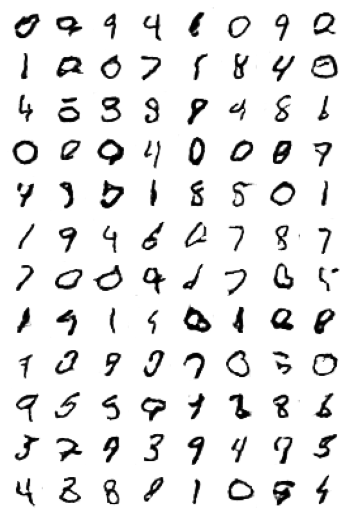

In [18]:
noise = torch.randn(batch_size, latent_size, 1, 1).to(device)

with torch.no_grad():
    fake_images = G(noise)
    # fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    show_images(fake_images)
